
## About Dataset
The original data came from the Cleveland database from the UCI Machine Learning Repository.

The following are the features which can be use to predict our target variable (heart disease or no heart disease).

- Age: The person’s age in years
- Sex: The person’s sex (1 = male, 0 = female)
- Cholesterol: The person’s cholesterol measurement in mg/dl
- RestingBP: Resting Blood Pressure
- FastingBS: The person’s fasting blood sugar (> 120 mg/dl, 1 = true; 0 = false)
- ChestPainType: The type of chest pain the patient has
   - ATA (atypical angina)
   - TA (typical angina)
   - ASY (asymptomatopic angina)
   - NAP (non angina pain)
- RestingECG: resting electrocardiographic results
    - LVH
    - Normal
    - ST
- MaxHR: The person’s maximum heart rate achieved
- ExerciseAngina: Exercise induced angina (1 = yes; 0 = no)
- Oldpeak: ST depression induced by exercise relative to rest (‘ST’ relates to positions on the ECG plot.
- ST_Slope: the slope of the peak exercise ST segment 
    - 1: down
    - 2: flat
    - 3: up
- HeartDisease: Heart disease (1 = no, 0= yes)



In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.feature_selection import RFE
from scipy.stats.mstats import winsorize
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import pickle
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings("ignore")
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from xgboost import XGBClassifier
import scipy.stats as stats
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
df = pd.read_csv('heart.csv')
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [3]:
# Getting information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [4]:
# Getting the shape of the dataset
print('There are {} rows and {} columns in the dataset'.format(df.shape[0], df.shape[1]))

There are 918 rows and 12 columns in the dataset


In [5]:
# Checking the percentage of missing values in each of the columns in the dataset. 
missing_df = pd.DataFrame((df.isnull().mean()*100), 
columns = ['missing value(%)'])
missing_df

,missing value(%)
Age,0.0
Sex,0.0
ChestPainType,0.0
RestingBP,0.0
Cholesterol,0.0
FastingBS,0.0
RestingECG,0.0
MaxHR,0.0
ExerciseAngina,0.0
Oldpeak,0.0


In [6]:
#Checking for duplicated rows or samples
print('There are {} duplicated rows'.format(df.duplicated().sum()))

There are 0 duplicated rows


In [7]:
# Getting a copy of the original dataset.
heart = df.copy()

In [8]:
heart['HeartDisease'] = heart['HeartDisease'].astype('category')
heart['FastingBS'] = heart['FastingBS'].astype('category')

In [9]:
# Getting summary statistics about the numerical columns in the dataset.
heart.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2


- The mean age of patients in the dataset is 54 years while the oldest is 77.
- The average cholesterol level of patients is 198.6, the minimum is 0 and the maximum level id 603.
- The mean MaxHR(maximum heart rate) achieved is  137 and maximum heart rate is 202.


In [10]:
# Getting summary statistics about the categorical columns in the dataset.
heart.describe(exclude = ['int', 'float']).T

,count,unique,top,freq
Sex,918,2,M,725
ChestPainType,918,4,ASY,496
FastingBS,918,2,0,704
RestingECG,918,3,Normal,552
ExerciseAngina,918,2,N,547
ST_Slope,918,3,Flat,460
HeartDisease,918,2,1,508


## Data Visualization

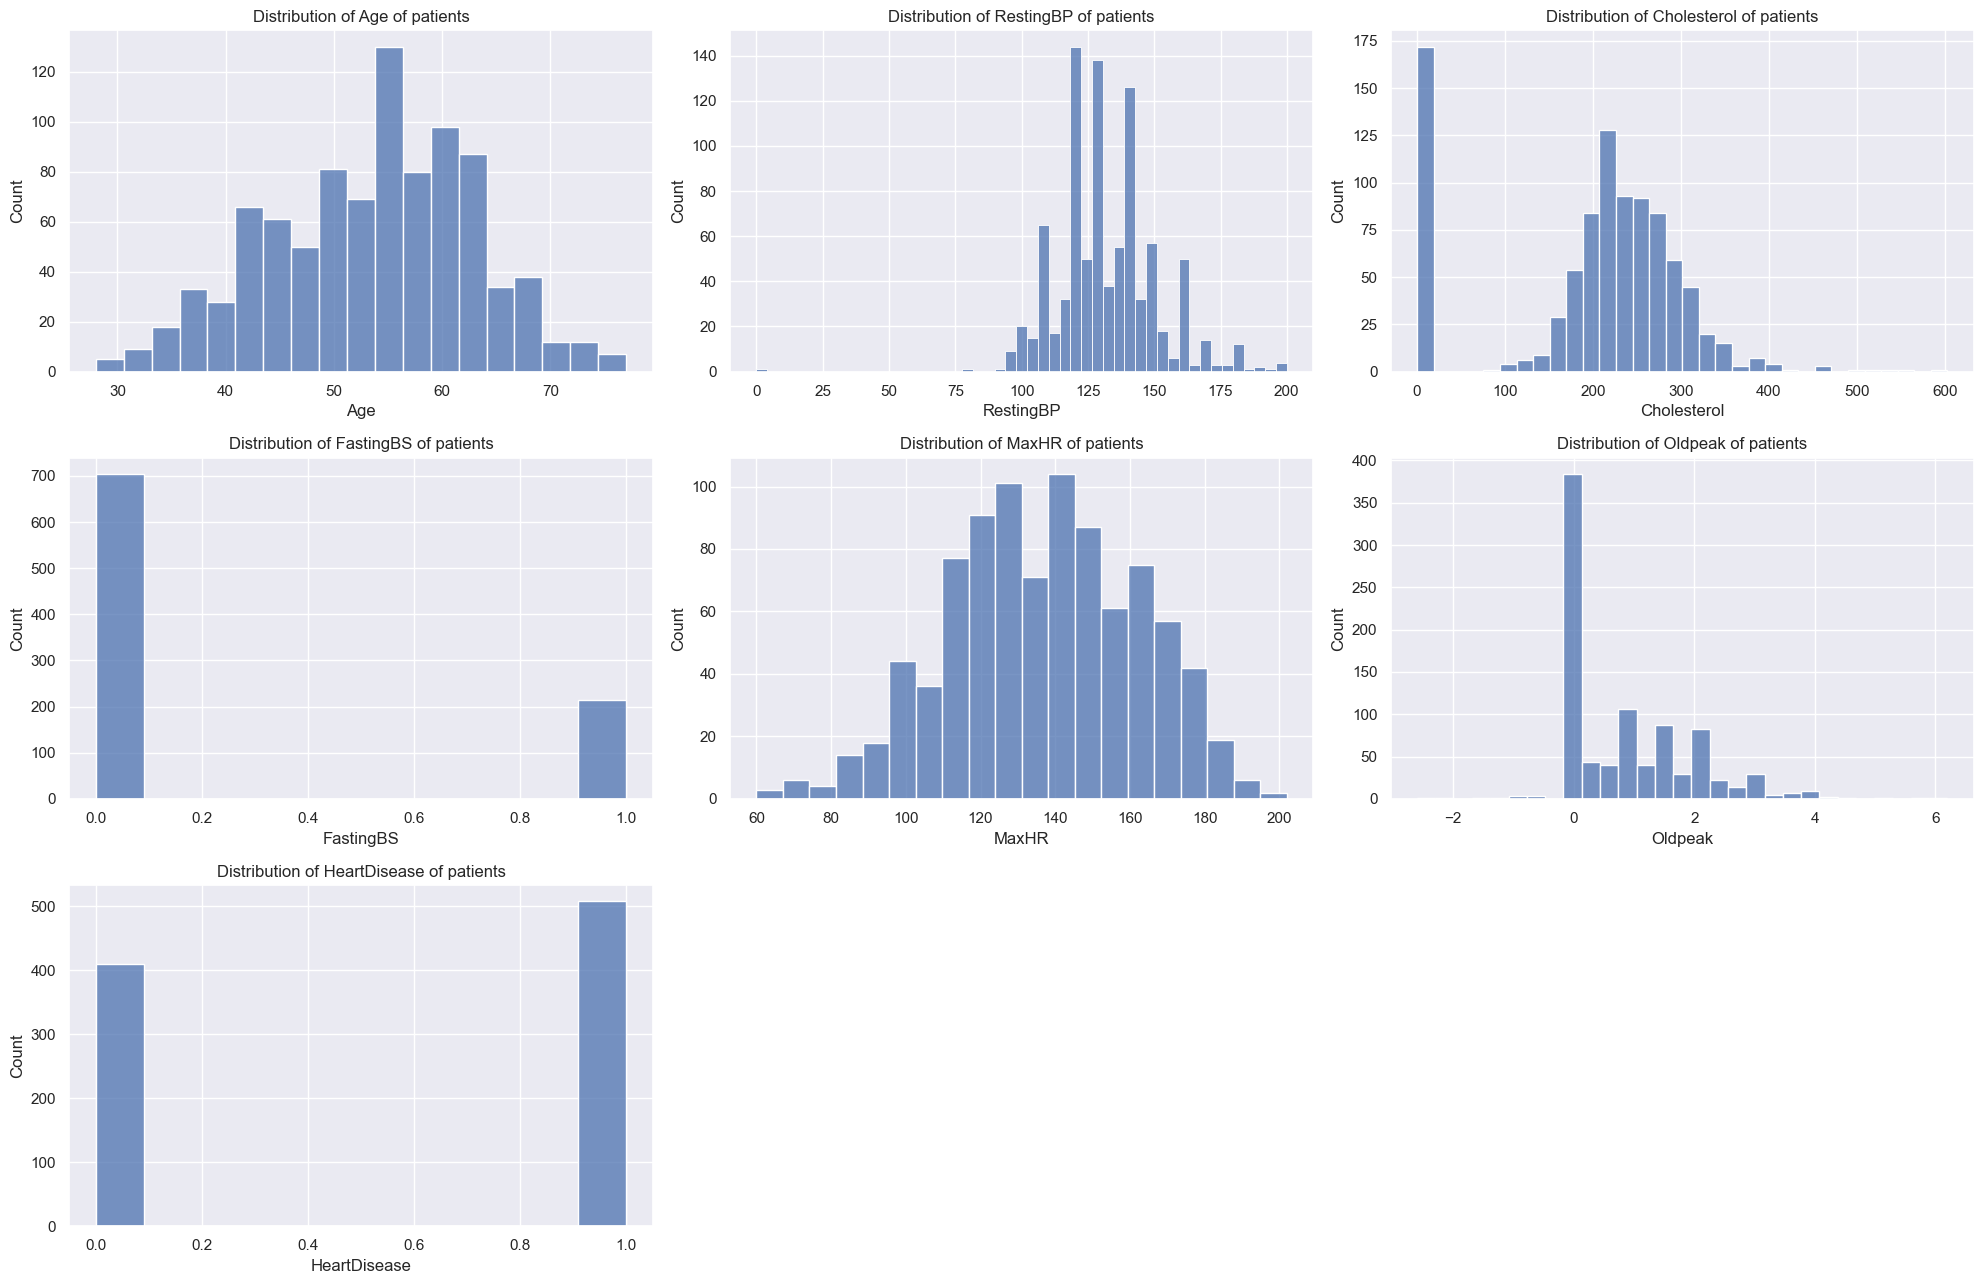

In [11]:
num_df = df.select_dtypes(include=['int', 'float'])

#  Categorical Data
a = 3  # number of rows
b = 3  # number of columns
c = 1  # initialize plot counter


sns.set()
fig = plt.figure(figsize=(20, 13))
for i in num_df.columns:
    plt.subplot(a, b, c)
    plt.title('Distribution of {} of patients'.format(i))
    plt.xlabel(i)
    sns.histplot(data = num_df, x=i)
    c = c + 1

plt.tight_layout()
plt.show()

- There is a huge count of patients aged 55.
- There are patients with resting blood pressure of zero.
- There are presence of outliers in the cholesterol columns. With most of the patients having a cholesterol level of zero.
- Out of the 918 patients in the dataset, 214 has a fasting blood sugar above 120 mg/dl. This is about 23.3% of the patients in the dataset.
- 410 patients in the dataset do not have any heart disease as compared to the 508 patients that has a heart disease

In [12]:
# Getting the coumts of patients with cholesterol level of zero
heart[heart.Cholesterol == 0].shape[0]

172

There are 172 patients with a cholesterol level of zero

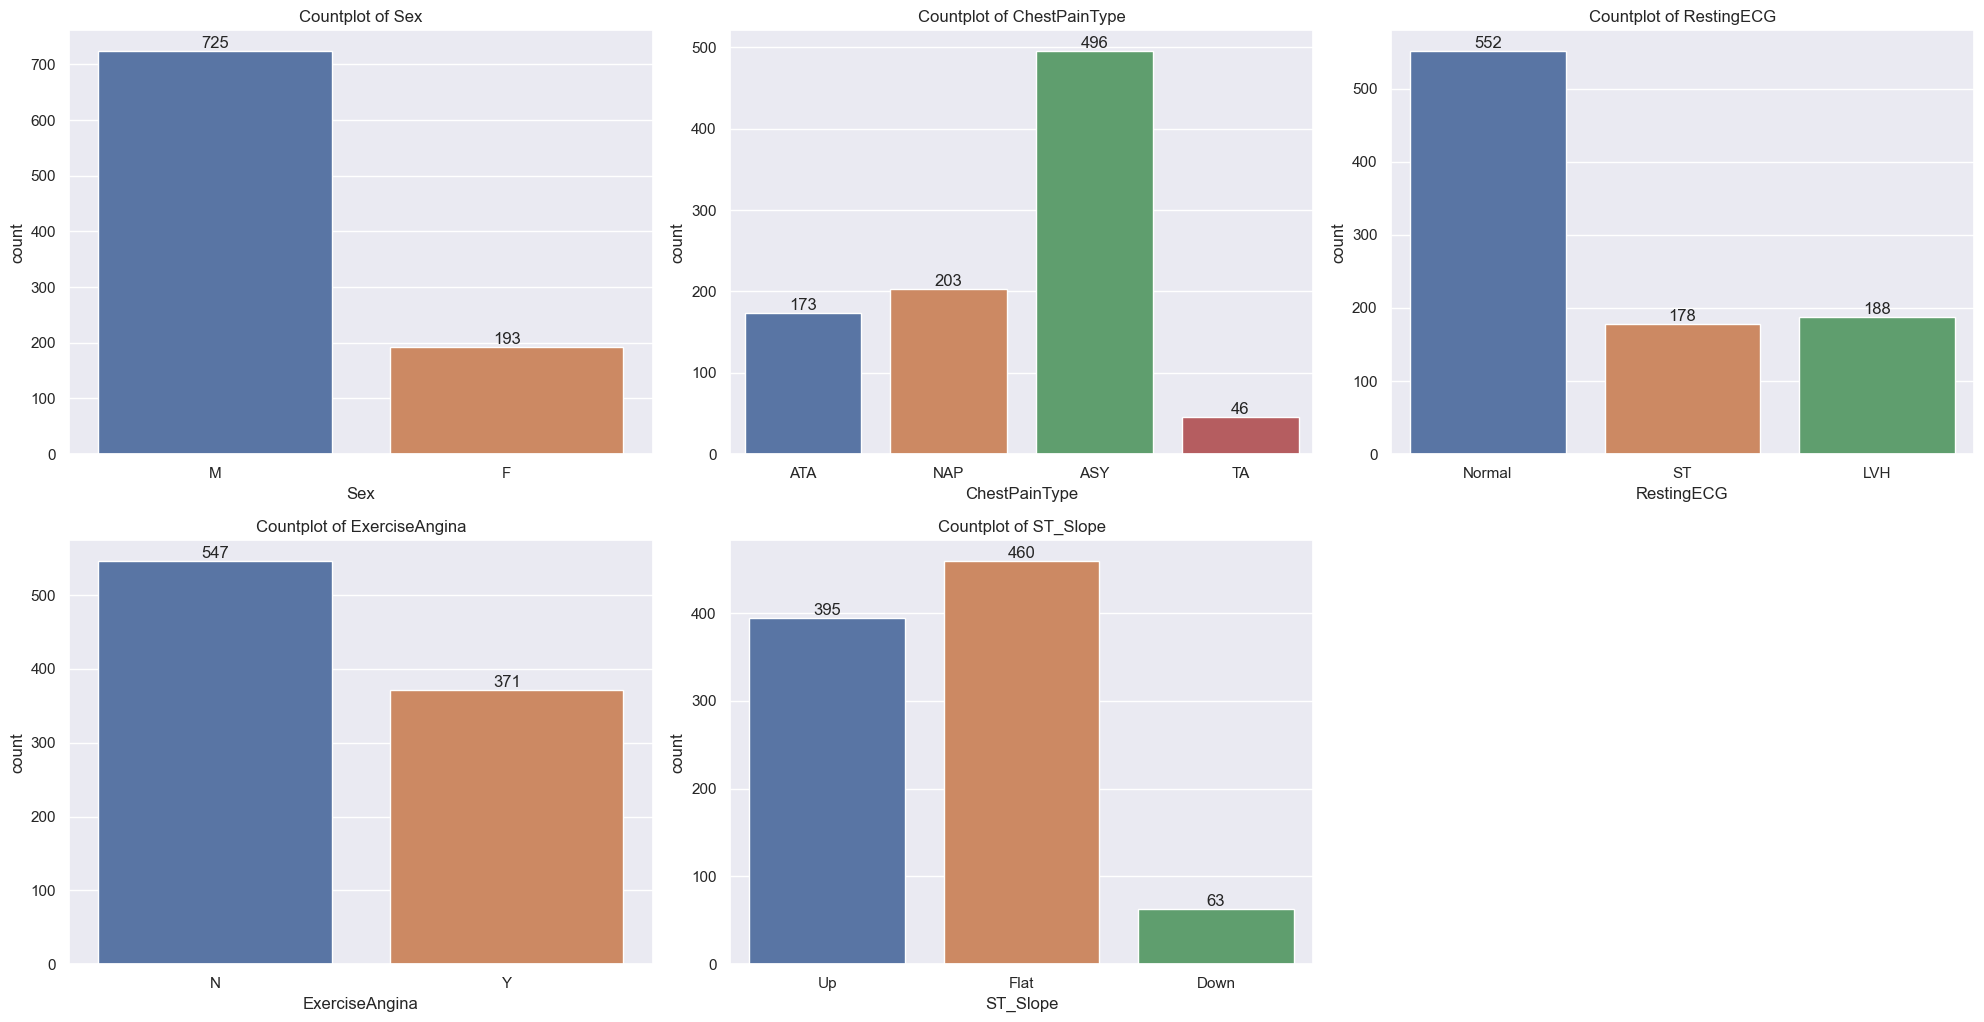

In [13]:
cat_df = df.select_dtypes(exclude=['int', 'float'])

#  Categorical Data
a = 3  # number of rows
b = 3  # number of columns
c = 1  # initialize plot counter
sns.set()
fig = plt.figure(figsize=(20, 15))
for i in cat_df.columns:
    plt.subplot(a, b, c)
    plt.title('Countplot of {}'.format(i))
    plt.xlabel(i)
    ax = sns.countplot(data = cat_df, x = i)
    for container in ax.containers:
        ax.bar_label(container)
    c = c + 1

plt.tight_layout()
plt.show()

- ASY(Asymptomatic) chest pain is the form of chest pain that affected the most patients i.e about 493 followed by the Non Angina chest pain type.
- 371 patients has exersise-induced angina while 547 patients do not have exercise induced angina.
- There are 725 male patients and 193 female patients.

In this section, we will observe the characteristics of patients with heart disease and patients without heart disease using both the numerical features.

In [14]:
def pivot_analysis(data, col1, col2):
    print(pd.pivot_table(df, index=col1, values=col2, aggfunc=np.mean))
    plt.figure(figsize=(15, 8))
    sns.boxplot(data=df, x=col1, y=col2, showmeans=True)
    plt.title('Distribution of {} for patients with stroke and patients without heart disease'.format(col2))

1. Ages of Patients within the two groups
***

                    Age
HeartDisease           
0             50.551220
1             55.899606


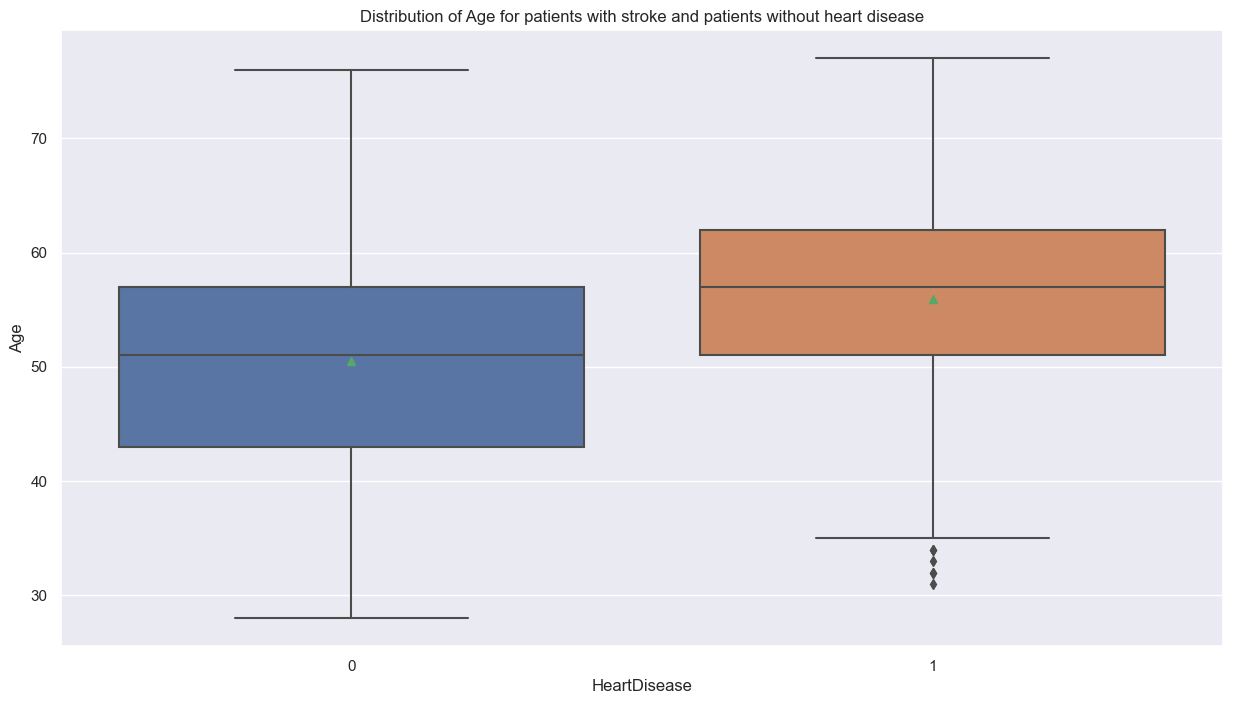

In [15]:
# Observing the mean age of patients and distribution of age with heart disease and patients without heart disease
pivot_analysis(df, 'HeartDisease', 'Age')

The mean age of patients with heart disease is higher than the mean age of patients without heart disease.

2. Resting BP of Patients within the two groups
***

               RestingBP
HeartDisease            
0             130.180488
1             134.185039


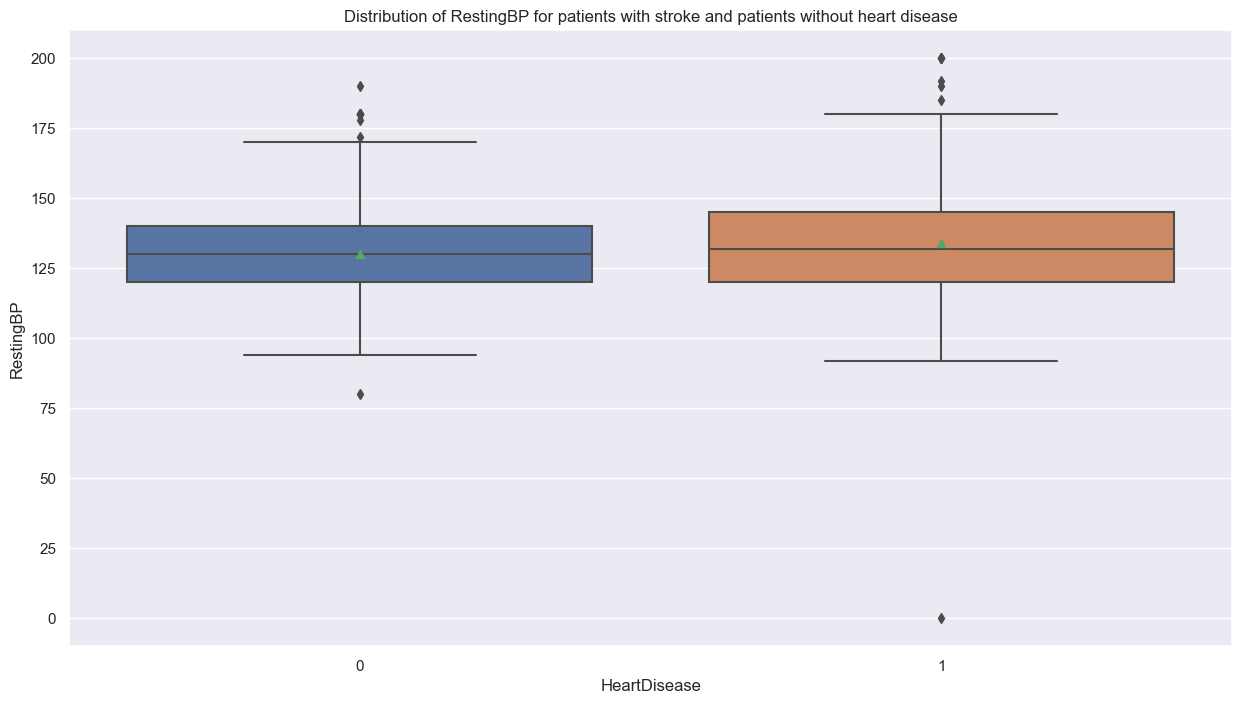

In [16]:
# Observing the mean resting blood and distribution of resting blood pressure for patients with stroke and patients without stroke
pivot_analysis(df, 'HeartDisease', 'RestingBP')

The mean resting blood pressure of patients with heart disease is higher than the mean resting blood pressure of patients without heart disease.

3. Cholesterol level of patients within the two groups
***

              Cholesterol
HeartDisease             
0              227.121951
1              175.940945


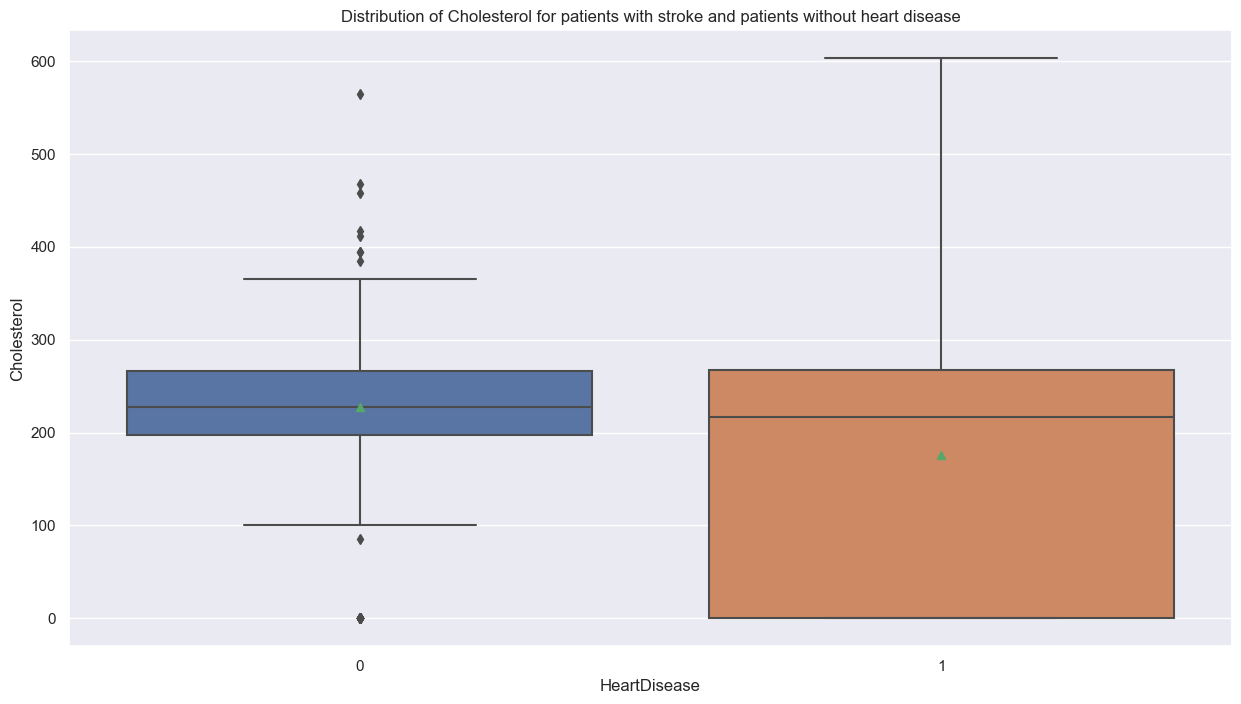

In [17]:
# Observing the mean cholesterol and distribution of cholesterol for patients with heart disease and patients without heart disease
pivot_analysis(df, 'HeartDisease', 'Cholesterol')

From the chart above, the mean cholesterol level of patients tends to be lower for patients with heart disease. A major reason for this skewness for the cholesterol level for patients with heart disease is because of the huge number of patients with cholesterol level of zero. A low cholesterol value as 0 is not physically possible. This values of zero will be considered as null values.

4. Maximum Heart Rate level of patients within the two groups
***

                   MaxHR
HeartDisease            
0             148.151220
1             127.655512


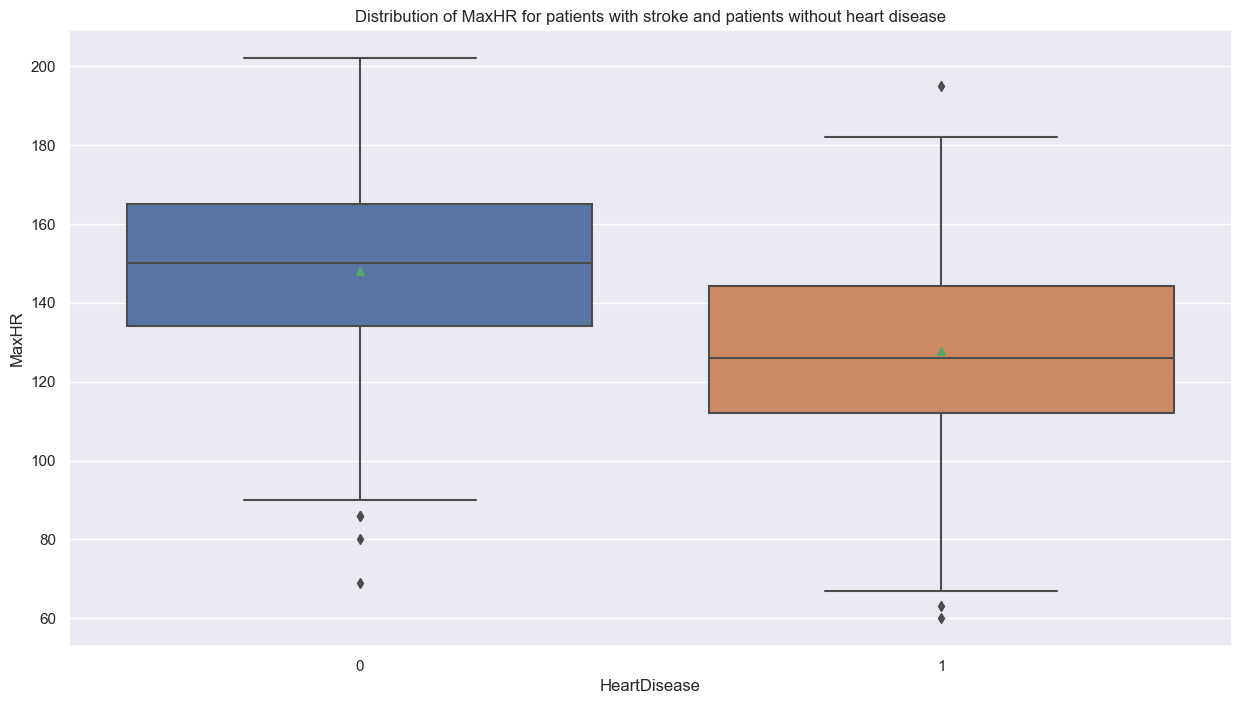

In [18]:
# Observing the mean Maximum heart and distribution of maximum heart rate for patients with heart disease and patients without heart disease
pivot_analysis(df, 'HeartDisease', 'MaxHR')

On average, patients with a heart disease tends to have a lower maximum heart rate than patients without a heart disease.

In [19]:
def contingency_analysis(data, col1, col2):
    print(pd.crosstab(df[col1], df[col2], margins=True))
    plt.figure(figsize=(15, 8))
    ax = sns.countplot(data=df, x=col2, hue=col1)
    plt.title('Counts of {} for patients with stroke and patients without Heart disease'.format(col2))
    for container in ax.containers:
        ax.bar_label(container)

ChestPainType  ASY  ATA  NAP  TA  All
HeartDisease                         
0              104  149  131  26  410
1              392   24   72  20  508
All            496  173  203  46  918


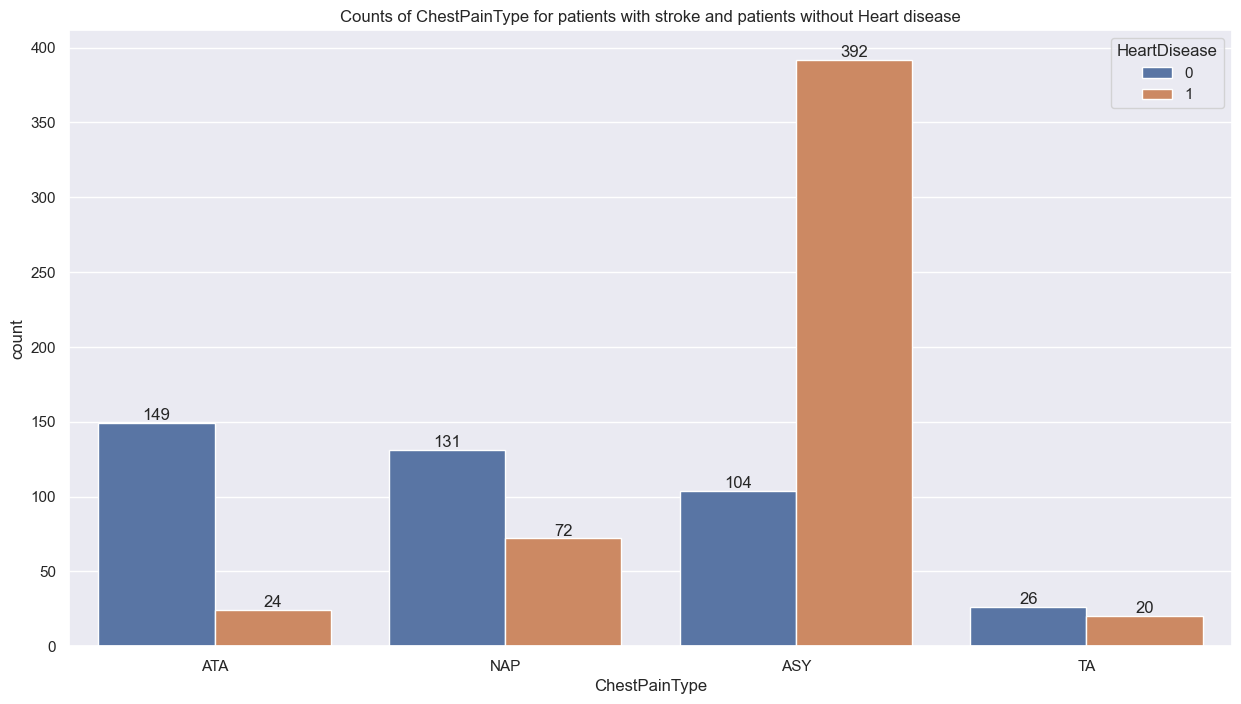

In [20]:
contingency_analysis(heart, 'HeartDisease', 'ChestPainType')

- The asymptomatic chest pain type is the most occuring chest pain type of all the patients.
- Patients with asymptomatic chest pain type (79%) are at high risk of developing or having heart diseases. This is followed by the typical angina chest pain type.(77%)

Sex             F    M  All
HeartDisease               
0             143  267  410
1              50  458  508
All           193  725  918


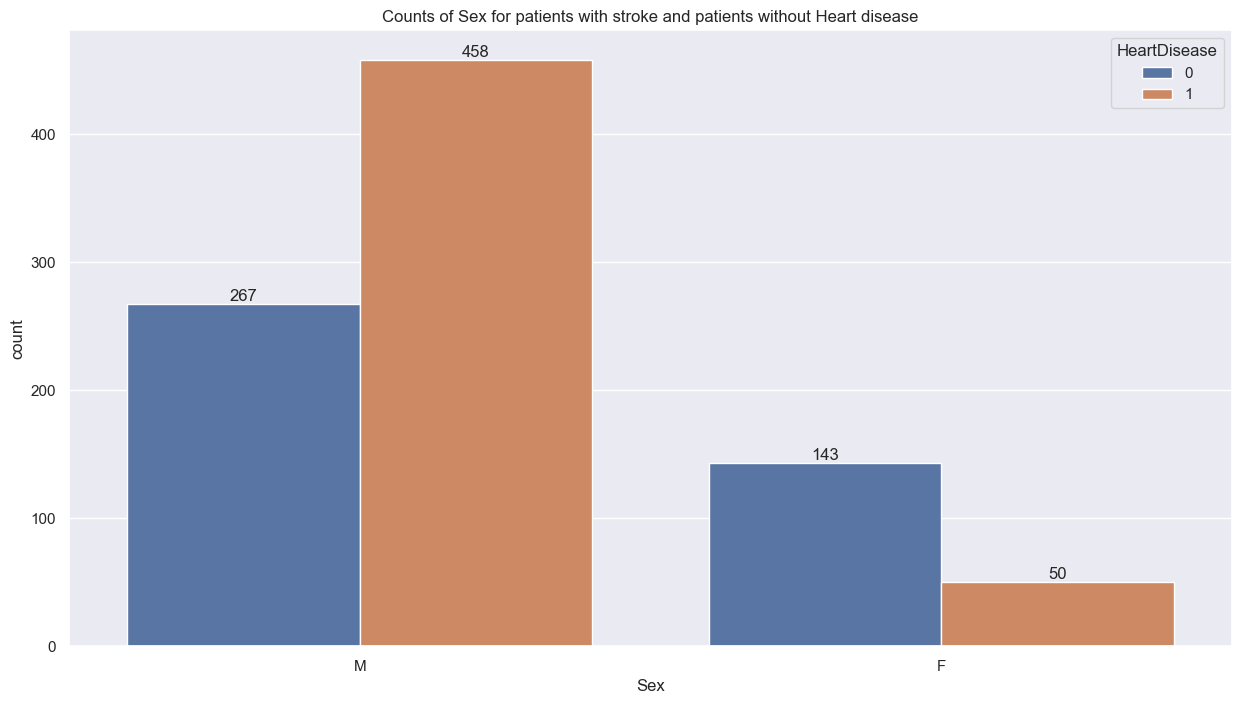

In [21]:
contingency_analysis(heart, 'HeartDisease', 'Sex')

- Male gender is the most common gender of the patients with a count of 725 patients. The female gender has a count of 193 patients.
- Men are at a higher risk of having heart diseases (63.17%).

ExerciseAngina    N    Y  All
HeartDisease                 
0               355   55  410
1               192  316  508
All             547  371  918


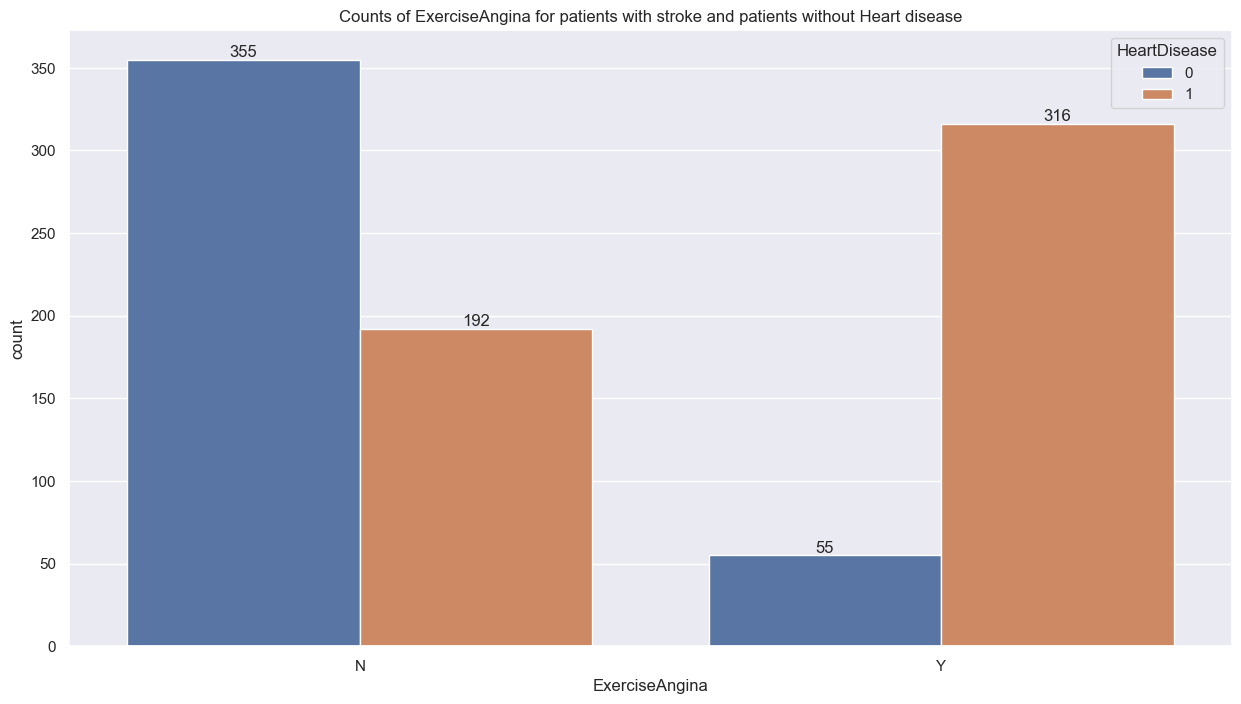

In [22]:
contingency_analysis(heart, 'HeartDisease', 'ExerciseAngina')

- People with exercise related angina are at a higher risk of having heart diseases (85.17%) than those without exercise related angina (35.10%).

ST_Slope      Down  Flat   Up  All
HeartDisease                      
0               14    79  317  410
1               49   381   78  508
All             63   460  395  918


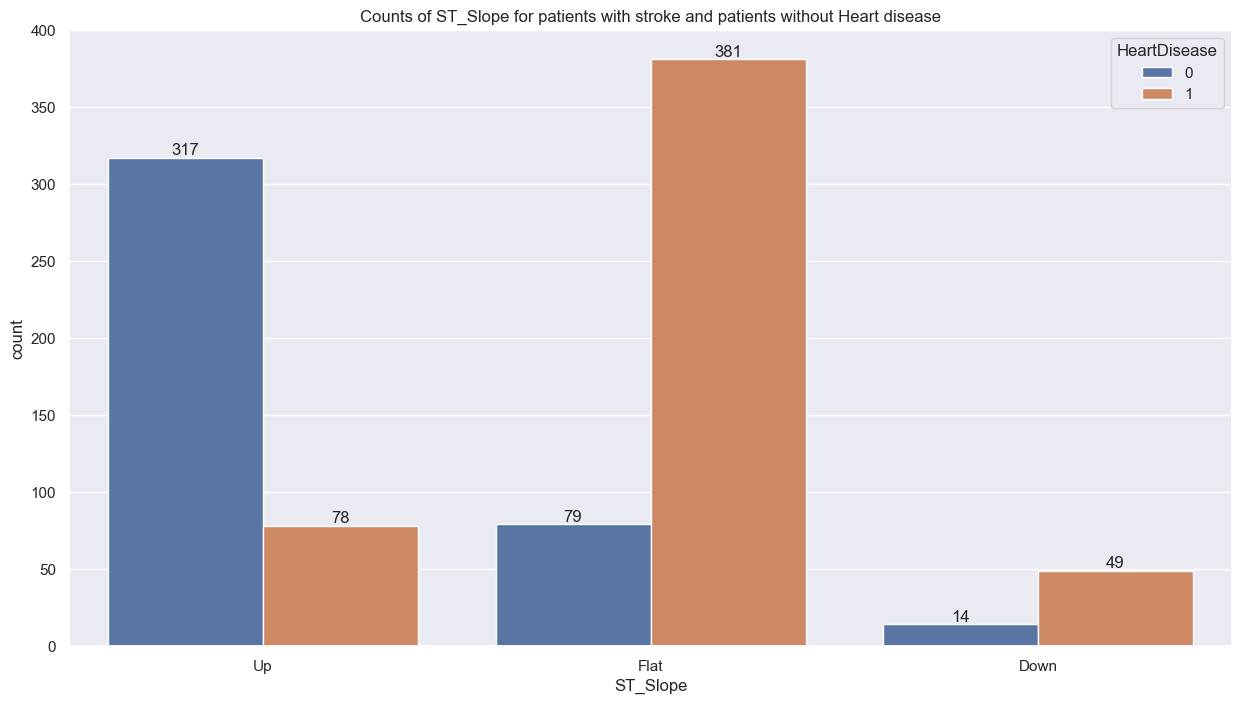

In [23]:
contingency_analysis(heart, 'HeartDisease', 'ST_Slope')

- Patients with a flat ST_Slope are at a higher risk of having heart diseases (82.82%) followed by patients with a dowt ST_Slope(77.78%).

## Hypothesis Testing

### T-Test

In this section, we will carry out the ttest to determine if the distribution of features are the same above groups of patients with heart disease and patients without heart disease.

- Null Hypothesis : The distribution of the numerical feature across both groups are the same.
- Alternate Hypothesis : The distribution of the numerical feature of patients with stroke is greater than that of patients without stroke.
- Alpha = 0.05.

Note: If the p value is greater than alpha(0.05), we accept the null hypothesis and if the p value is lesser than alpha(0.05), we reject the null hypothesis.

In [24]:
# A function to perform the ttest between columns in the dataframe
def pairwise_ttest(data, num_cols, cat_cols):
    t_test_matrix = pd.DataFrame(index=num_cols, columns=cat_cols)
    for num_col in num_cols:
        for cat_col in cat_cols:
            for cat_val in sorted(data[cat_col].unique()):
                group1 = data[data[cat_col] == cat_val][num_col]
                group2 = data[data[cat_col] != cat_val][num_col]
                t_stat, p_val = stats.ttest_ind(
                    group1, group2, equal_var = False, nan_policy='omit', alternative='less')
                t_test_matrix.at[num_col, cat_col] = round(p_val, 6)
    return t_test_matrix

In [25]:
num_cols = heart.select_dtypes(include=['int', 'float']).dropna().columns
cat_col = ['HeartDisease']

In [26]:
ttest = pairwise_ttest(heart, num_cols, cat_col)
ttest

,HeartDisease
Age,1.0
RestingBP,0.999563
Cholesterol,0.0
MaxHR,0.0
Oldpeak,1.0


The numerical values in the table represents the pvalue for the t test.
- Age and HeartDisease: Accept the null hypothesis(p-value = 1).
- RestingBP and HeartDisease: Accept the null hypothesis(p-value = 0.999452).
- Oldpeak and HeartDisease: Accept the null hypothesis(p-value = 1).
- Cholesterol and HeartDisease: Reject the null hypothesis(p-value = 0.0).
- MaxHR and HeartDisease: Accept the null hypothesis(p-value = 1).


### Chisquare Contingency Test for Association.

In this section, we will carry out the ttest to determine if there are any association between categorical features in the dataset. 

- Null Hypothesis : There is no association between the two columns.
- Alternate Hypothesis : There is an association between the two columns.
- Alpha = 0.05.

Note: If the p value is greater than alpha(0.05), we accept the null hypothesis and if the p value is lesser than alpha(0.05), we reject the null hypothesis.

In [28]:
# Perform chi-square test for each pair of columns
def pairwise_chi_square_test(df):
    columns = df.columns
    num_columns = len(columns)
    p_values = {}

    for i in range(num_columns):
        for j in range(i + 1, num_columns):
            contingency_table = pd.crosstab(df[columns[i]], df[columns[j]])
            chi2, p, _, _ = stats.chi2_contingency(contingency_table)
            p_values[(columns[i], columns[j])] = p

    return p_values

In [27]:
cat_df = heart.select_dtypes(include=['category', 'O'])

In [29]:
p_values = pairwise_chi_square_test(cat_df)
print("Pairwise Chi-Square Test P-Values:")
print('-' * 50, '\n')
for pair, p_value in p_values.items():
    print(f"{pair}: {p_value}, \n")

Pairwise Chi-Square Test P-Values:
-------------------------------------------------- 

('Sex', 'ChestPainType'): 4.880336281360552e-08, 

('Sex', 'FastingBS'): 0.00039659385688841134, 

('Sex', 'RestingECG'): 0.08912244139807841, 

('Sex', 'ExerciseAngina'): 1.2387163558796499e-08, 

('Sex', 'ST_Slope'): 1.83174739624214e-05, 

('Sex', 'HeartDisease'): 4.5976174508091635e-20, 

('ChestPainType', 'FastingBS'): 2.8819665653307156e-05, 

('ChestPainType', 'RestingECG'): 0.003596780905759451, 

('ChestPainType', 'ExerciseAngina'): 1.2659099121635848e-38, 

('ChestPainType', 'ST_Slope'): 2.705381063690865e-31, 

('ChestPainType', 'HeartDisease'): 8.08372842808765e-58, 

('FastingBS', 'RestingECG'): 0.0004947858901824468, 

('FastingBS', 'ExerciseAngina'): 0.07976859509438532, 

('FastingBS', 'ST_Slope'): 6.914947257487285e-07, 

('FastingBS', 'HeartDisease'): 1.0573018731809955e-15, 

('RestingECG', 'ExerciseAngina'): 0.004941141203261243, 

('RestingECG', 'ST_Slope'): 0.10329552404263315,

### Test for Association


In this section, test for the degree of statistical association between the categorical columns are carried out using the Cramers V test for association.


Note: Statistical association does not in any way denote causation. Just because there is a high degree of association between two features does not mean one feature causes another. It just means that changes in the value of one feature is consistent with the change in value for another feature.



                Cramer's V               Relationship type
                -------------------|----------------------------
                < 0.10             |           Weak association
                > 0.10 and < 0.25  |           Moderate association
                > 0.25 and < 1     |           Strong association
                1                  |           Perfect association

In [30]:
col_names = heart.select_dtypes(include = ['O', 'category']).columns
matrix = pd.DataFrame(columns = col_names, index = col_names)
matrix

,Sex,ChestPainType,FastingBS,RestingECG,ExerciseAngina,ST_Slope,HeartDisease
Sex,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ChestPainType,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FastingBS,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RestingECG,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ExerciseAngina,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ST_Slope,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HeartDisease,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
outercnt = 0
innercnt = 0

for i in col_names:
    for j in col_names:
        crosstab_df = pd.crosstab(heart[i], heart[j])
        p_val = stats.contingency.association(crosstab_df, method = 'cramer')
        matrix.iloc[outercnt, innercnt] = p_val
        innercnt+=1
    outercnt+=1
    innercnt = 0

In [32]:
matrix

,Sex,ChestPainType,FastingBS,RestingECG,ExerciseAngina,ST_Slope,HeartDisease
Sex,1.0,0.200433,0.120076,0.072577,0.190664,0.154156,0.305445
ChestPainType,0.200433,1.0,0.160685,0.102687,0.441913,0.292316,0.540382
FastingBS,0.120076,0.160685,1.0,0.128773,0.060451,0.175792,0.267291
RestingECG,0.072577,0.102687,0.128773,1.0,0.107559,0.064751,0.109123
ExerciseAngina,0.190664,0.441913,0.060451,0.107559,1.0,0.456648,0.494282
ST_Slope,0.154156,0.292316,0.175792,0.064751,0.456648,1.0,0.622664
HeartDisease,0.305445,0.540382,0.267291,0.109123,0.494282,0.622664,1.0


    Features                             Association type               Cramer's V
    ----------------------------------|----------------------------|--------------------
    Heart Disease and sex             |      Strong association    |  0.305
    Heart disease and Chest Pain Type |      Strong association    |  0.540
    Heart Disease and FastingBS       |      Strong association    |  0.267
    Heart disease and RestingECG      |      Weak association      |  0.109
    Heart Disease and Exercise Angina |      Strong association    |  0.494
    Heart Disease and ST_Slope        |      Strong association    |  0.623
    ST_Slope and Exercise Angina      |      Strong association    |  0.457
    Sex and Exercise Angina           |      Moderate association  |  0.191
    Sex and ChestPainType             |      Moderate association  |  0.200
    ChestPainType and ExerciseAngina  |      Moderate association  |  0.442

### Correlation Analysis


In this section, test for the degree of statistical correlation between the numerical columns are carried out using the correlation coefficient.

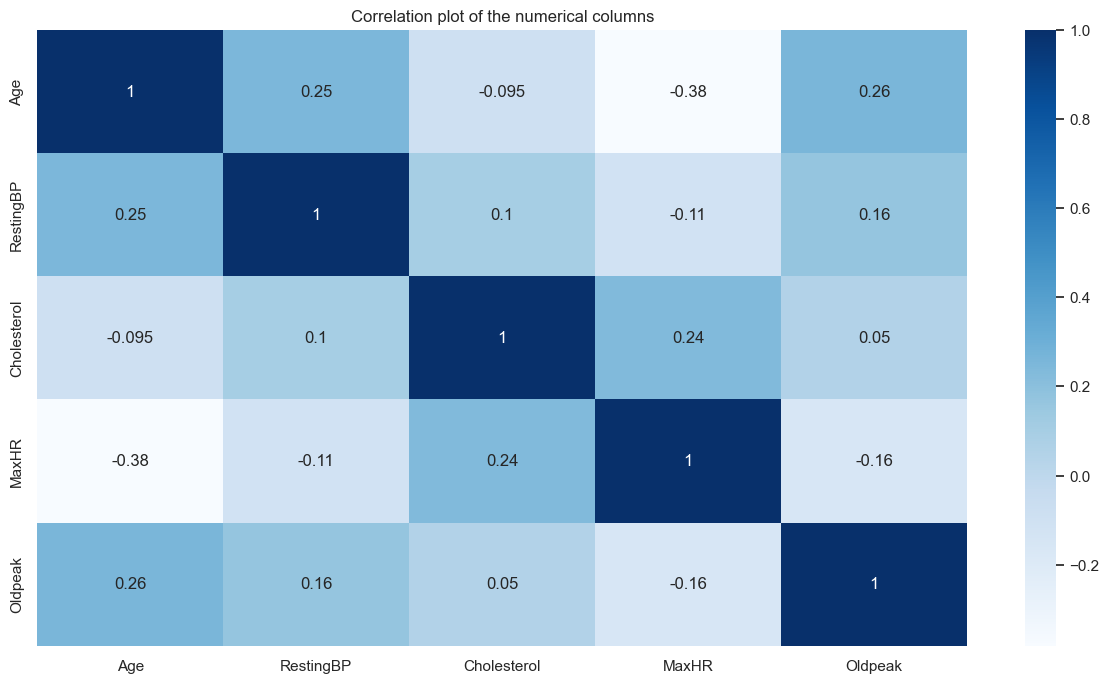

In [33]:
# Getting the correlation heatmap using the spearman's correlation coefficient
plt.figure(figsize = (15, 8))
sns.heatmap(heart.corr(), annot = True, cmap= 'Blues')
plt.title('Correlation plot of the numerical columns')
plt.show()

<strong>Summary<br>
A value below 0 represents a negative correlation i.e as the value of one increases, the other decreases and a value above 0 represents a positive correlation meaning as the value of one column increases, the other increases.
- There is a positive correlation between RestingBP and Age(0.25). This shows that resting blood pressure increses with increasing age.
- There is a negative correlation between maxHR(maximum heart rate) and Age(-0.38). This means that maximum heart rate reduces with increasing age.
- There is a positive correlation between maximum heart rate and cholesterol levels(0.24) that is to say that higher masimum heart rate increases with increasing cholesterol levels.

## Data Preprocessing


In this section, we prepare the dataset for modelling.

### Feature Engineering



In this section, new features will be engineered from new features.

In [34]:
# Categorizing the ages of patients into age groups such as young middle aged and senior.
bins = [20, 40, 60, np.inf]
labels = ['young', 'middle aged', 'senior']
heart['age_group'] = pd.cut(heart['Age'], bins, labels = labels)

In [35]:
# Categorizing the resting blood pressure of patients into groups such as low, normal and high.
bins = [0, 90, 120, np.inf]
labels = ['low', 'normal', 'high']
heart['bp_group'] = pd.cut(heart['RestingBP'], bins, labels = labels)

The values of 0 in the cholesterol and resting blood pressure column is obviously an error as this value is not feasible. This values will first be converted to a null value and then be imputed using the KNNImputer.

In [36]:
# Converting the values of zero in the Cholesterol and resting blood pressure columns to null values.
heart.Cholesterol.replace(0, np.nan, inplace = True)
heart.RestingBP.replace(0, np.nan, inplace = True)
numerical_df = heart.select_dtypes(exclude = ['object', 'category'])
# Imputing these null values with a value using the KNNImputer class
imputer = KNNImputer(n_neighbors = 5)
imputed_data = imputer.fit_transform(numerical_df)

In [37]:
cols = numerical_df.columns
heart[cols] = imputed_data

In [38]:
# Categorizing the cholesterol level of patients into groups such as normal, borderline and high.
bins = [0, 200, 240, np.inf]
labels = ['normal', 'borderline', 'high']
heart['chol_group'] = pd.cut(heart['Cholesterol'], bins, labels = labels)

In [39]:
#One hot encoding the categorical columns in the dataset.
heart = pd.get_dummies(heart, columns = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'age_group', 'bp_group', 'chol_group'], drop_first = True)

In [40]:
# Splitting the dataset into independent features and target feature.
x = heart.drop(['HeartDisease'], axis = 1)
y = heart['HeartDisease']

In [41]:
#Splitting the data into training and test sets; 70% for training and 30% for testing or validating the model
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 15, stratify = y)

## Feature Selection

Important features necessary to predict the HeartDiasease variable which is the target column are selected from the dataset. This will be done using the RFE algorithm.

RFE is an iterative process that works as follows:

- Train the model on all the features and rank them based on their importance.
- Eliminate the least important feature.
- Repeatedly train the model on the remaining features and eliminate the least significant feature until the desired number of features is reached.
- RFE considers the interaction between features and their impact on the model’s performance.

In [42]:
#Instantiating the random forest regressor model for feature selection
rf = RandomForestClassifier()

In [43]:
# Instantiating the REE class and picking the best 15 features 
selector= RFE(estimator= rf, n_features_to_select = 15)
selector.fit_transform(x_train, y_train)

array([[ 44., 130., 209., ...,   0.,   1.,   1.],
       [ 61., 120., 337., ...,   1.,   0.,   0.],
       [ 65., 144., 312., ...,   1.,   0.,   0.],
       ...,
       [ 68., 120., 211., ...,   1.,   0.,   1.],
       [ 56., 150., 230., ...,   1.,   0.,   1.],
       [ 67., 120., 229., ...,   1.,   0.,   1.]])

In [44]:
selected = x.columns[selector.get_support()]
print('The selected features are {}'.format(list(selected)))

The selected features are ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'Sex_M', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA', 'RestingECG_Normal', 'ExerciseAngina_Y', 'ST_Slope_Flat', 'ST_Slope_Up', 'chol_group_borderline']


## Data Modelling




This modelling task is a classification task. The performance metric of each model to be built is the 'Recall','Precision' and the Accuracy metric. The accuracy metric cannot be used due to the nature of the class imbalance in the dataset. 

- Recall shows whether a model can find all objects of a target class. The recall is the ratio of correct predicitons and the total number of correct items. It indicates how good a model is at predicting the correct class.
- Precision shows how often an ML model is correct when predicting the target class. It is the ratio between the correct predictions and the total predictions. It indicates how good a model is at whatever it predicted. 
- Accuracy represents the number of correct predictions.<br><br><br>

For this phase in this step of the project, the following steps will be taken:
- Cross validating the model.
- Fitting the model on the whole training set.
- Carrying out hyperparameter tuning to determine the optimum model parameters.
- Comparing model's performance.







In [45]:
# Split the data using StratifiedKFold and get the average performance metrics score
def cross_validate(model, xtrain, ytrain):
    # Function for the cross validation of models.
    skf = StratifiedKFold()
    mean_accuracy = 0
    for train_ix, test_ix in skf.split(xtrain, ytrain):
        X_train, X_test = xtrain.iloc[train_ix], xtrain.iloc[test_ix]
        Y_train, Y_test = ytrain.iloc[train_ix], ytrain.iloc[test_ix]
        # Import the function that computes class weights

        model.fit(X_train, Y_train)
        predictions = model.predict(X_test)
        mean_accuracy += accuracy_score(Y_test, predictions)

    print(f'Mean Training Accuracy Score: {mean_accuracy / skf.n_splits}')

In [46]:
def modelling(model_name, model , xtrain , ytrain , xtest , ytest):
    # A function to train and validate the model using evaluation metrics
    model.fit(xtrain.values , ytrain.values)
    pred= model.predict(xtest)
    train_score = model.score(xtrain.values, ytrain.values)
    test_score = accuracy_score(ytest, pred)
    report = classification_report(pred, ytest)
    matrix = confusion_matrix(pred, ytest)
    recall = recall_score(pred, ytest)
    precision = precision_score(pred, ytest)
    print('MODEL: {}'.format(model_name))
    print('-' * 80)
    print('Training Accuracy is : {}%'.format(round(train_score * 100), 2))
    print('Test Accuracy is {}%'.format(round(test_score * 100), 2))
    print('The classification report : \n {} '.format(report))
    sns.heatmap(matrix, annot = True, xticklabels = y.unique(), yticklabels = y.unique(), cmap = 'Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix for the {} model'.format(model_name))
    plt.show()

In [47]:
# Instantiating all the algorithms we will use to build our models.
log = LogisticRegression(random_state = 105) 
rf = RandomForestClassifier(random_state = 105)
dt = DecisionTreeClassifier(random_state = 105)
knn = KNeighborsClassifier()
svc = SVC(random_state = 105)

### Logistic Regression

In [48]:
#Cross validating the logistic regression model...
cross_validate(log, x_train[selected], y_train)

Mean Training Accuracy Score: 0.8520227713178293


MODEL: Logistic Regression
--------------------------------------------------------------------------------
Training Accuracy is : 86%
Test Accuracy is 88%
The classification report : 
               precision    recall  f1-score   support

           0       0.83      0.89      0.86       114
           1       0.92      0.87      0.90       162

    accuracy                           0.88       276
   macro avg       0.88      0.88      0.88       276
weighted avg       0.88      0.88      0.88       276
 


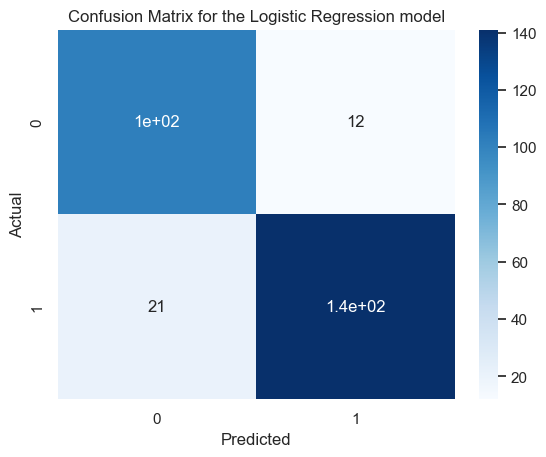

In [49]:
log_model_results = modelling('Logistic Regression', log, x_train[selected], y_train,
                              x_test[selected], y_test)
log_model_results

#### Hyperparameter Tuning of the Logistic Regression Model.

In [50]:
# Declaring feature space
param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 1000,2500, 5000]
    }
]

In [51]:
random_estimator_log = RandomizedSearchCV(estimator=log,
                                          param_distributions=param_grid,
                                          n_iter=5,
                                          scoring='accuracy',
                                          n_jobs=-1,
                                          verbose=1,
                                          random_state=1,
                                          )

In [52]:
random_estimator_log.fit(x_train[selected], y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(estimator=LogisticRegression(random_state=105), n_iter=5,
                   n_jobs=-1,
                   param_distributions=[{'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                         'max_iter': [100, 1000, 2500, 5000],
                                         'penalty': ['l1', 'l2', 'elasticnet',
                                                     'none'],
                                         'solver': ['lbfgs', 'newton-cg',
                                                    'liblinear', 'sag',
                                                    'saga']}],
                   random_state=1, scoring='accuracy', verbose=1)

MODEL: Fine Tuned Logistic Regression
--------------------------------------------------------------------------------
Training Accuracy is : 86%
Test Accuracy is 88%
The classification report : 
               precision    recall  f1-score   support

           0       0.83      0.90      0.86       113
           1       0.93      0.87      0.90       163

    accuracy                           0.88       276
   macro avg       0.88      0.89      0.88       276
weighted avg       0.89      0.88      0.88       276
 


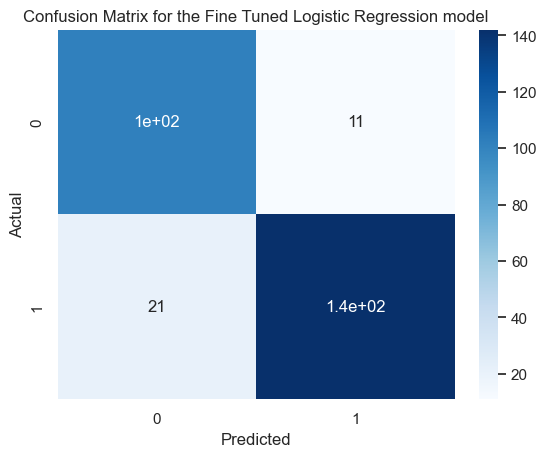

In [53]:
log_tuned_model_results = modelling('Fine Tuned Logistic Regression', random_estimator_log.best_estimator_, x_train[selected], y_train,
                                    x_test[selected], y_test)
log_tuned_model_results

The hyperparameter tuning of the logistic regression model did not significantly increase its performance metrics.

### Random Forest

In [54]:
# Cross validating the random forest model...
cross_validate(rf, x_train[selected], y_train)

Mean Training Accuracy Score: 0.8457485465116278


MODEL: Random Forest Classifier
--------------------------------------------------------------------------------
Training Accuracy is : 100%
Test Accuracy is 89%
The classification report : 
               precision    recall  f1-score   support

           0       0.85      0.90      0.88       117
           1       0.92      0.89      0.90       159

    accuracy                           0.89       276
   macro avg       0.89      0.89      0.89       276
weighted avg       0.89      0.89      0.89       276
 


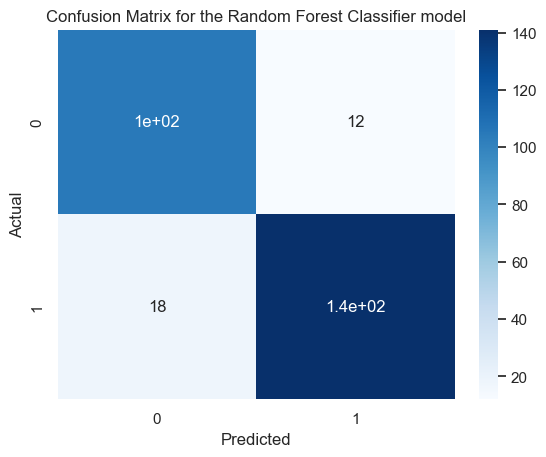

In [55]:
rf_model_results = modelling('Random Forest Classifier', rf, x_train[selected], y_train,
                              x_test[selected], y_test)
rf_model_results

The difference between the accuracy in the cross validation(84.57%) and the training accuracy in the fitting of the model(100%) clearly shows that the random forest classifier model is overfitting on the training data.

#### Hyperparameter tuning of the random forest classifier model.

In [56]:
random_grid = {
    "max_depth": [5, 7, 9, 11],
    "min_samples_leaf": [2, 3, 5, 7, 9],
    "min_samples_leaf": [2, 3, 4, 5, 6],
    "max_features": [5, 10, 15, 20],
}
random_estimator_rf = RandomizedSearchCV(estimator=rf,
                                         param_distributions=random_grid,
                                         n_iter=3,
                                         scoring='accuracy',
                                         n_jobs=-1,
                                         cv=3,
                                         verbose=1,
                                         random_state=1,
                                         )

In [57]:
random_estimator_rf.fit(x_train[selected], y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=105),
                   n_iter=3, n_jobs=-1,
                   param_distributions={'max_depth': [5, 7, 9, 11],
                                        'max_features': [5, 10, 15, 20],
                                        'min_samples_leaf': [2, 3, 4, 5, 6]},
                   random_state=1, scoring='accuracy', verbose=1)

MODEL: Fine Tuned Random Forest
--------------------------------------------------------------------------------
Training Accuracy is : 94%
Test Accuracy is 87%
The classification report : 
               precision    recall  f1-score   support

           0       0.80      0.88      0.84       112
           1       0.92      0.85      0.88       164

    accuracy                           0.87       276
   macro avg       0.86      0.87      0.86       276
weighted avg       0.87      0.87      0.87       276
 


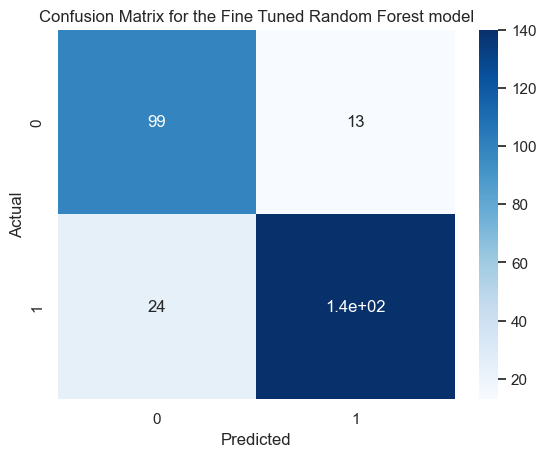

In [58]:
rf_tuned_model_results = modelling('Fine Tuned Random Forest', random_estimator_rf.best_estimator_, x_train[selected], y_train,
                                   x_test[selected], y_test)
rf_tuned_model_results

The hyper parameter tuning of the random forest classifier model did not greatly increase the performance metrics of the original random forest classifier model.

### Decision Tree Classifier

In [59]:
# Cross validating the Decision tree model...
cross_validate(dt, x_train[selected], y_train)

Mean Training Accuracy Score: 0.7787911821705427


MODEL: Decision Tree Classifier
--------------------------------------------------------------------------------
Training Accuracy is : 100%
Test Accuracy is 78%
The classification report : 
               precision    recall  f1-score   support

           0       0.75      0.75      0.75       122
           1       0.80      0.80      0.80       154

    accuracy                           0.78       276
   macro avg       0.78      0.78      0.78       276
weighted avg       0.78      0.78      0.78       276
 


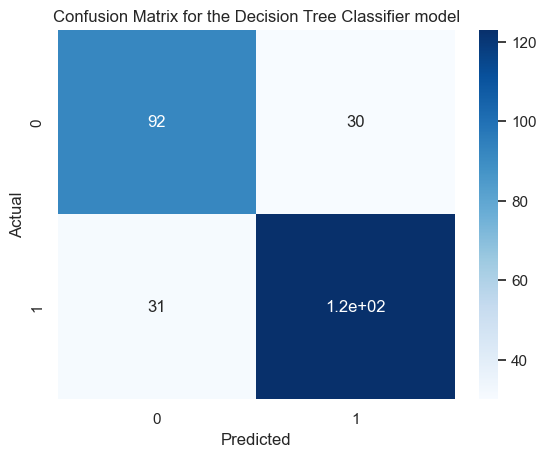

In [60]:
dt_model_results = modelling('Decision Tree Classifier', dt, x_train[selected], y_train,
                              x_test[selected], y_test)
dt_model_results

The difference between the accuracy in the cross validation(77.9%) and the training accuracy in the fitting of the model(100%) clearly shows that the Decision Tree classifier model is overfitting on the training data.

#### Hyper parameter tuning of the Decision tree Model

In [61]:
random_grid = {
    "max_features": [5, 10, 20],
    "max_depth": [5, 7, 9, 11],
    "min_samples_leaf": [2, 3, 5, 7, 9],
    "min_samples_leaf": [2, 3, 4, 5, 6]
}
random_estimator_dt = RandomizedSearchCV(estimator=dt,
                                         param_distributions=random_grid,
                                         n_iter=3,
                                         scoring='accuracy',
                                         n_jobs=-1,
                                         cv=3,
                                         verbose=1,
                                         random_state=1,
                                         )

In [62]:
random_estimator_dt.fit(x_train[selected], y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


RandomizedSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=105),
                   n_iter=3, n_jobs=-1,
                   param_distributions={'max_depth': [5, 7, 9, 11],
                                        'max_features': [5, 10, 20],
                                        'min_samples_leaf': [2, 3, 4, 5, 6]},
                   random_state=1, scoring='accuracy', verbose=1)

MODEL: Fine Tuned Decision Tree
--------------------------------------------------------------------------------
Training Accuracy is : 84%
Test Accuracy is 82%
The classification report : 
               precision    recall  f1-score   support

           0       0.72      0.86      0.78       102
           1       0.91      0.80      0.85       174

    accuracy                           0.82       276
   macro avg       0.81      0.83      0.82       276
weighted avg       0.84      0.82      0.83       276
 


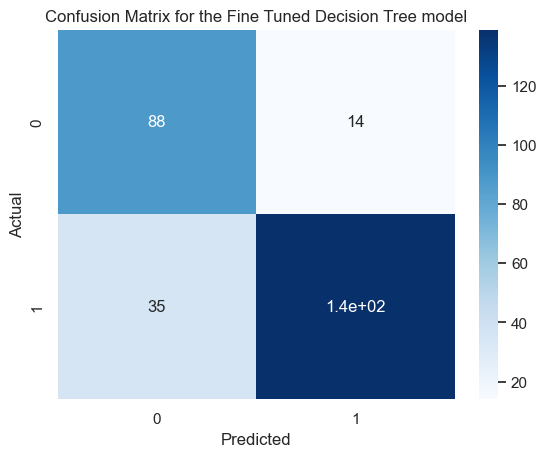

In [63]:
dt_tuned_model_results = modelling('Fine Tuned Decision Tree', random_estimator_dt.best_estimator_, x_train[selected], y_train,
                                   x_test[selected], y_test)
dt_tuned_model_results

The hyper parameter tuning of the Decision tree classifier model did not greatly increase the performance metrics of the original model.

### K-Nearrest Neighbors Classifier

In [64]:
# Cross validating the KNN model...
cross_validate(knn, x_train[selected], y_train)

Mean Training Accuracy Score: 0.6338662790697674


MODEL: KNN
--------------------------------------------------------------------------------
Training Accuracy is : 75%
Test Accuracy is 67%
The classification report : 
               precision    recall  f1-score   support

           0       0.57      0.65      0.61       107
           1       0.76      0.69      0.72       169

    accuracy                           0.67       276
   macro avg       0.66      0.67      0.66       276
weighted avg       0.68      0.67      0.68       276
 


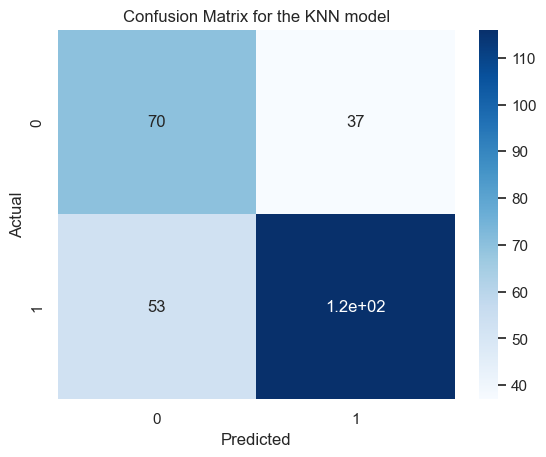

In [65]:
knn_model_results = modelling('KNN', knn, x_train[selected], y_train,
                              x_test[selected], y_test)
knn_model_results

The train accuracy gotten from the modelling phase is different than the one gotten from the cross validation phase. This shows that the KNN Model is overfitting.

#### Hyperparameter tuning of the KNN Model

In [66]:
random_grid = {
    "n_neighbors": range(1, 10, 1),
    "weights": ['uniform', 'distance'],
    "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute'],
    "p": [1, 2, 3, 4, 5, 6]
}
random_estimator_knn = RandomizedSearchCV(estimator=knn,
                                         param_distributions=random_grid,
                                         n_iter=3,
                                         scoring='accuracy',
                                         n_jobs=-1,
                                         cv=3,
                                         verbose=1,
                                         random_state=1,
                                         )

In [67]:
random_estimator_knn.fit(x_train[selected], y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


RandomizedSearchCV(cv=3, estimator=KNeighborsClassifier(), n_iter=3, n_jobs=-1,
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'n_neighbors': range(1, 10),
                                        'p': [1, 2, 3, 4, 5, 6],
                                        'weights': ['uniform', 'distance']},
                   random_state=1, scoring='accuracy', verbose=1)

MODEL: Fine Tuned KNN
--------------------------------------------------------------------------------
Training Accuracy is : 79%
Test Accuracy is 71%
The classification report : 
               precision    recall  f1-score   support

           0       0.62      0.69      0.65       110
           1       0.78      0.72      0.75       166

    accuracy                           0.71       276
   macro avg       0.70      0.70      0.70       276
weighted avg       0.71      0.71      0.71       276
 


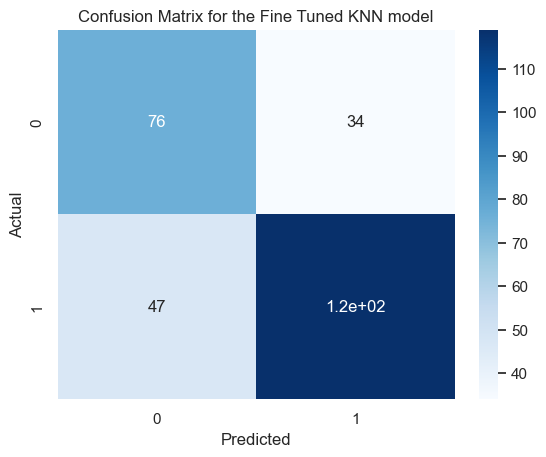

In [68]:
knn_tuned_model_results = modelling('Fine Tuned KNN', random_estimator_knn.best_estimator_, x_train[selected], y_train,
                                   x_test[selected], y_test)
knn_tuned_model_results

The hyperparameter tuning of the KNN model improved the performance of the model in general but not as much when compared to previously built models.

### Support Vector Classifier

In [69]:
# Cross validating the SVC model...
cross_validate(svc, x_train[selected], y_train)

Mean Training Accuracy Score: 0.669718992248062


MODEL: Support Vector Classifier
--------------------------------------------------------------------------------
Training Accuracy is : 67%
Test Accuracy is 74%
The classification report : 
               precision    recall  f1-score   support

           0       0.59      0.77      0.67        95
           1       0.86      0.72      0.78       181

    accuracy                           0.74       276
   macro avg       0.72      0.75      0.73       276
weighted avg       0.77      0.74      0.74       276
 


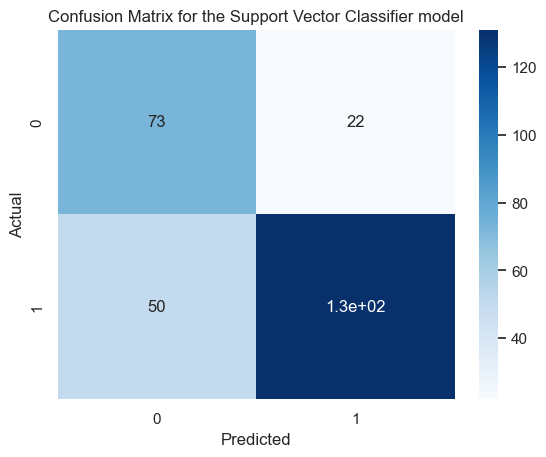

In [70]:
svc_model_results = modelling('Support Vector Classifier', svc, x_train[selected], y_train,
                              x_test[selected], y_test)
svc_model_results

### Hyperparameter Tuning of the SVC Model.

In [72]:
params = {
    'probability': [True],
    'C': [0.1, 1, 10],
    'gamma': [1, 0.1, 0.01],
    'kernel': ['linear', 'rbf']
}
random_estimator_svc = RandomizedSearchCV(estimator=svc,
                                          param_distributions=params,
                                          n_iter=3,
                                          scoring='accuracy',
                                          n_jobs=-1,
                                          cv=3,
                                          verbose=1,
                                          random_state=1,
                                          )

In [73]:
random_estimator_svc.fit(x_train[selected], y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


RandomizedSearchCV(cv=3, estimator=SVC(random_state=105), n_iter=3, n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10],
                                        'gamma': [1, 0.1, 0.01],
                                        'kernel': ['linear', 'rbf'],
                                        'probability': [True]},
                   random_state=1, scoring='accuracy', verbose=1)

MODEL: Fine Tuned SVC
--------------------------------------------------------------------------------
Training Accuracy is : 86%
Test Accuracy is 89%
The classification report : 
               precision    recall  f1-score   support

           0       0.83      0.92      0.87       111
           1       0.94      0.87      0.91       165

    accuracy                           0.89       276
   macro avg       0.89      0.90      0.89       276
weighted avg       0.90      0.89      0.89       276
 


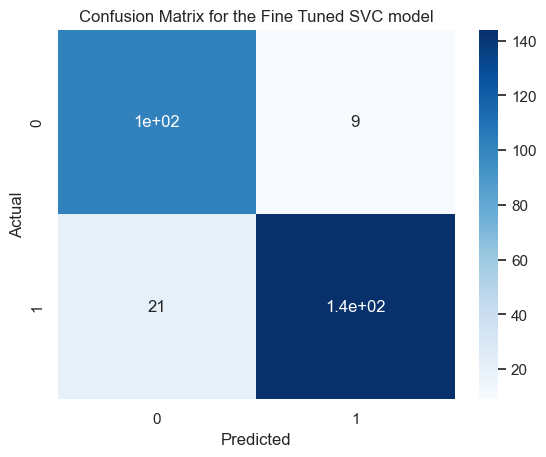

In [74]:
svc_tuned_model_results = modelling('Fine Tuned SVC', random_estimator_svc.best_estimator_, x_train[selected], y_train,
                                   x_test[selected], y_test)
svc_tuned_model_results

The SVC model performed better after hyperparameter tuning. It performed better than all other models built so far. So therefore, the fined tuned SVC model is taken as the final model.


<b> Final Model: 
SVC(C=1, gamma=1, kernel='linear', random_state=105)

In [75]:
# Saving the model....
link = open(r'svc_heart.pkl', 'wb')
pickle.dump(random_estimator_svc.best_estimator_, link)
link.close()